# 中国上市公司财务特征分析


## A . 列表呈现下述指标在 2000-今 期间各个年度的 平均值，中位数，标准差，最小值 和 最大值，并作简要分析。

> Hints:   
1. 可以查文献确定各个变量的最佳计算方式；
2. 若有些指标的起始记录年份晚于 2000 年，以实际提供时间为准；
3. 离群值可以在 1 和 99 百分位上进行缩尾处理。

- Lev = 总负债率 = 总负债/总资产
- SL = 流动负债率 = 流动负债/总资产
- LL = 长期负债率 = 长期负债/总资产
- SDR = 短债比率 = 流动负债/总负债
- Cash = 现金比率 = 公司年末持有的现金和现金等价物/总资产
- ROA = 净利润/总资产
- ROE = 净利润/净资产
- SLoan = 短期银行借款/总资产
- LLoan = 长期银行借款/总资产
- Top1 = 第一大股东持股比例
- HHI5 = 前五大股东持股比例平方之和 (赫芬达尔指数)

In [64]:
# 导入所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib
from scipy import stats
from matplotlib.ticker import PercentFormatter
from datetime import datetime
from matplotlib import rcParams
import warnings
warnings.filterwarnings("ignore")

# 设置字体为 SimHei（黑体）解决中文乱码
rcParams['font.family'] = 'SimHei'

# 避免负号 '-' 显示为方块
rcParams['axes.unicode_minus'] = False

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [46]:
# 处理异常值的函数 - Winsorize at 1% and 99%
def winsorize_series(series):
    return stats.mstats.winsorize(series, limits=[0.01, 0.01])

# 计算财务比率统计数据的函数
def calculate_stats(data, ratio_name):
    stats_df = pd.DataFrame({
        '均值': data.groupby('year')[ratio_name].mean().round(3),
        '中位数': data.groupby('year')[ratio_name].median().round(3),
        '标准差': data.groupby('year')[ratio_name].std().round(3),
        '最小值': data.groupby('year')[ratio_name].min().round(3),
        '最大值': data.groupby('year')[ratio_name].max().round(3)
    })
    return stats_df

# 绘制时间序列图的函数 - 均值和中位数
def plot_time_series(data, ratio_name, title, ylabel, ylim=None):
    fig, ax = plt.subplots()
    
    # 绘制均值和中位数曲线
    ax.plot(data.index, data['均值'], marker='o', linestyle='-', label='均值')
    ax.plot(data.index, data['中位数'], marker='s', linestyle='--', label='中位数')
    
    ax.set_title(title)
    ax.set_xlabel('年份')
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    if ylim:
        ax.set_ylim(ylim)
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    return fig

# 绘制双变量时间序列图的函数 - 双Y轴
def plot_dual_time_series(data1, data2, ratio1_name, ratio2_name, title):
    fig, ax1 = plt.subplots()
    
    color1 = 'tab:blue'
    ax1.set_xlabel('年份')
    ax1.set_ylabel(ratio1_name, color=color1)
    ax1.plot(data1.index, data1['均值'], marker='o', linestyle='-', color=color1, label=ratio1_name)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # 创建第二个Y轴
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel(ratio2_name, color=color2)
    ax2.plot(data2.index, data2['均值'], marker='s', linestyle='--', color=color2, label=ratio2_name)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    ax1.set_title(title)
    
    # 添加图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.tight_layout()
    return fig

# 绘制行业时间序列图的函数
def plot_industry_time_series(data, industries, industry_names, ratio_name, title):
    fig, ax = plt.subplots()
    
    for industry in industries:
        industry_data = data[data['industry_code'] == industry]
        if not industry_data.empty:
            stats_df = calculate_stats(industry_data, ratio_name)
            ax.plot(stats_df.index, stats_df['均值'], marker='o', linestyle='-', 
                   label=industry_names.get(industry, industry))
    
    ax.set_title(title)
    ax.set_xlabel('年份')
    ax.set_ylabel(ratio_name)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    return fig

# 从各种日期格式中提取年份的函数
def extract_year(date_str):
    try:
        # 尝试不同的日期格式
        for fmt in ['%Y/%m/%d', '%Y-%m-%d', '%Y%m%d', '%Y']:
            try:
                dt = datetime.strptime(str(date_str).strip(), fmt)
                return dt.year
            except ValueError:
                continue
        
        # 如果特定格式失败，尝试更简单的方法，如"2000/12/31"
        if '/' in str(date_str):
            return int(str(date_str).split('/')[0])
        elif '-' in str(date_str):
            return int(str(date_str).split('-')[0])
        else:
            # 最后的尝试：假设前4个字符可能是年份
            return int(str(date_str)[:4])
    except:
        return None


In [47]:
# 读取数据
file_path='processed_stock_data.csv'
print(f"读取数据文件: {file_path}...")
if not os.path.exists(file_path):
    print(f"错误: 文件 {file_path} 不存在!")

data = pd.read_csv(file_path, encoding="GBK")
data.head()

读取数据文件: processed_stock_data.csv...


,date,tot_assets,tot_liab,tot_cur_liab,tot_non_cur_liab,st_borrow,lt_borrow,tot_equity,monetary_cap,net_profit,holder_pct,holder_sumsqupcttop5,industry_CSRC,code
0,2001/12/31,1201.2698,1164.9931,821.6941,343.2990,0.0,0.0,36.2767,3.7931,4.0236,8.96,145.2190,金融业,000001.SZ
1,2002/12/31,1661.6638,1623.9836,1312.1233,311.8603,0.0,0.0,37.6802,5.1522,4.3222,7.08,112.8473,金融业,000001.SZ
2,2003/12/31,1934.5342,1890.5853,1483.6695,406.9157,0.0,0.0,43.9489,5.8979,3.1655,7.08,113.1321,金融业,000001.SZ
3,2004/12/31,2042.8642,1996.0176,1848.1667,147.8509,0.0,0.0,46.8466,7.0308,2.8977,17.89,112.8473,金融业,000001.SZ
4,2005/12/31,2223.2469,2172.7028,0.0000,0.0000,0.0,0.0,50.5441,0.0000,3.1101,17.89,335.6238,金融业,000001.SZ


In [48]:
# 主函数：执行所有分析
def load_and_process_data(data):
    # 处理日期格式并提取年份
    print("处理日期格式...")
    # 对每个日期字符串应用extract_year函数
    data['year'] = data['date'].apply(extract_year)
    
    # 检查年份提取是否成功
    missing_years = data['year'].isna().sum()
    if missing_years > 0:
        print(f"警告: 无法从 {missing_years} 行数据中提取年份。")
        print("问题日期值样例:", data[data['year'].isna()]['date'].head())
    
    # 过滤2000年及以后的数据
    data = data[data['year'] >= 2000]
    print(f"筛选出 {len(data)} 行2000年及以后的数据。")
    
    # 确保数值列是数值类型
    numeric_cols = ["tot_assets", "tot_liab", "tot_cur_liab", "tot_non_cur_liab", 
                    "st_borrow", "lt_borrow", "tot_equity", "monetary_cap", "net_profit",
                    "holder_pct", "holder_sumsqupcttop5"]
    
    for col in numeric_cols:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # 计算财务比率
    print("计算财务比率...")
    
    # Lev = 总负债 / 总资产
    data['Lev'] = data['tot_liab'] / data['tot_assets']
    
    # SL = 流动负债 / 总资产
    data['SL'] = data['tot_cur_liab'] / data['tot_assets']
    
    # LL = 非流动负债 / 总资产
    data['LL'] = data['tot_non_cur_liab'] / data['tot_assets']
    
    # SDR = 流动负债 / 总负债
    data['SDR'] = data['tot_cur_liab'] / data['tot_liab']
    
    # Cash = 货币资金 / 总资产
    data['Cash'] = data['monetary_cap'] / data['tot_assets']
    
    # ROA和ROE计算
    data['ROA'] = data['net_profit'] / data['tot_assets']
    data['ROE'] = data['net_profit'] / data['tot_equity']
    
    # SLoan = 短期借款 / 总资产
    data['SLoan'] = data['st_borrow'] / data['tot_assets']
    
    # LLoan = 长期借款 / 总资产
    data['LLoan'] = data['lt_borrow'] / data['tot_assets']
    
    # Top1 = 第一大股东持股比例
    data['Top1'] = data['holder_pct']
    
    # HHI5 = 前五大股东赫芬达尔指数
    data['HHI5'] = data['holder_sumsqupcttop5']
    
    # 替换无穷值为NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    print("数据处理完成。")

    return data

In [49]:
# 加载和处理数据
data = load_and_process_data(data=data)

处理日期格式...
筛选出 96299 行2000年及以后的数据。
计算财务比率...
数据处理完成。


In [69]:
## 1. 财务比率统计分析（2000年至今）
### 计算和展示各指标的均值、中位数、标准差、最小值和最大值

# 定义要分析的财务比率
ratio_cols = ['Lev', 'SL', 'LL', 'SDR', 'Cash', 'SLoan', 'LLoan', 'Top1', 'HHI5', 'ROA', 'ROE']

# 为每个比率计算统计数据
ratio_stats = {}
for ratio in ratio_cols:
    if ratio in data.columns:
        ratio_stats[ratio] = calculate_stats(data, ratio)

# 创建结果目录
os.makedirs('results', exist_ok=True)

# 显示并保存各比率的统计数据
for ratio, stats_df in ratio_stats.items():
    print(f"\n{ratio} 统计数据:")
    print("=" * 20)
    display(stats_df)
    
    # 保存到CSV
    stats_df.to_csv(f'results/{ratio}_stats.csv')



Lev 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,0.454091,0.444572,0.205524,0.009073,2.893638
2001,0.474442,0.458988,0.316210,0.000000,7.151769
2002,0.502080,0.470979,0.394465,0.000000,8.502066
2003,0.516863,0.503592,0.319326,0.010832,4.882735
2004,0.552194,0.521843,0.553855,0.008140,16.328489
2005,0.619678,0.550401,1.235877,0.000000,43.070663
2006,1.192251,0.560300,24.255110,0.000000,1026.318182
2007,0.689098,0.536193,3.506530,0.000000,123.893617
2008,0.678089,0.518209,3.714696,0.000000,146.000000



SL 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,0.385254,0.366088,0.190068,-0.045026,2.171066
2001,0.394349,0.375411,0.220714,0.000000,3.982018
2002,0.417932,0.391413,0.276857,0.000000,4.950458
2003,0.426809,0.408940,0.229053,0.000000,3.011420
2004,0.452115,0.434293,0.324297,0.000000,7.956951
2005,0.497454,0.456841,0.749056,0.000000,25.201020
2006,1.031360,0.457623,22.394490,0.000000,948.363636
2007,0.567147,0.436308,3.231326,0.000000,123.893617
2008,0.556555,0.421253,3.322584,0.000000,146.000000



LL 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,0.067720,0.031249,0.108680,-0.104536,2.114958
2001,0.078997,0.034962,0.224996,0.000000,6.829773
2002,0.082262,0.034164,0.186240,0.000000,3.551609
2003,0.086073,0.038835,0.166284,0.000000,2.697066
2004,0.092199,0.036461,0.290600,0.000000,8.371538
2005,0.106426,0.031736,0.539327,0.000000,17.869643
2006,0.139730,0.031122,1.925057,0.000000,77.954545
2007,0.093188,0.026341,0.621365,0.000000,25.485820
2008,0.094545,0.019864,0.899486,0.000000,40.896437



SDR 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,0.856854,0.924591,0.179071,-0.093985,1.284775
2001,0.848732,0.923925,0.185925,0.000000,1.000000
2002,0.849655,0.922313,0.185604,0.000000,1.000000
2003,0.845197,0.915641,0.191822,0.000000,1.004763
2004,0.846349,0.921789,0.193582,0.000000,1.000000
2005,0.844332,0.928986,0.209015,0.000000,1.000000
2006,0.844859,0.928855,0.213451,0.000000,1.000000
2007,0.838107,0.932752,0.228521,0.000000,1.000000
2008,0.844469,0.945121,0.228067,0.000000,1.000000



Cash 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,0.159595,0.121522,0.131355,0.000036,0.816986
2001,0.171948,0.140432,0.125742,0.000000,1.000000
2002,0.162999,0.135703,0.119867,0.000000,0.688347
2003,0.159004,0.131112,0.120310,0.000000,0.823623
2004,0.155826,0.127725,0.121669,0.000000,0.909153
2005,0.141283,0.114233,0.116375,0.000000,0.786001
2006,0.151484,0.121268,0.124657,0.000000,0.846567
2007,0.177370,0.137342,0.152069,0.000000,0.947205
2008,0.180428,0.141901,0.150149,0.000000,1.000000



SLoan 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,0.154916,0.136023,0.127173,0.0,1.143737
2001,0.166678,0.150019,0.138604,0.0,1.597111
2002,0.170080,0.151120,0.172987,0.0,3.217013
2003,0.178256,0.159969,0.154184,0.0,1.664570
2004,0.182651,0.160131,0.199639,0.0,4.810529
2005,0.188991,0.154510,0.387742,0.0,13.260204
2006,0.433765,0.138280,11.010140,0.0,466.136364
2007,0.168758,0.125226,0.571161,0.0,18.613402
2008,0.159878,0.123965,0.548981,0.0,25.699889



LLoan 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,0.057270,0.020934,0.098534,0.0,1.996118
2001,0.064387,0.018802,0.201452,0.0,6.317040
2002,0.059556,0.018750,0.090530,0.0,0.764102
2003,0.060875,0.021622,0.090947,0.0,0.815234
2004,0.059225,0.017002,0.098944,0.0,1.815739
2005,0.057341,0.010619,0.098751,0.0,1.574732
2006,0.054160,0.006720,0.088990,0.0,0.604243
2007,0.048889,0.000570,0.084948,0.0,0.582192
2008,0.047201,0.000000,0.087155,0.0,0.717793



Top1 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,10.839349,0.0000,21.360402,0.00,99.00
2001,11.180068,0.0000,21.213418,0.00,85.00
2002,11.776017,0.0000,21.437028,0.00,100.00
2003,12.254727,0.0000,21.488282,0.00,100.00
2004,13.017736,0.0000,21.607722,0.00,100.00
2005,12.918290,0.0000,21.063697,0.00,100.00
2006,12.802746,0.0000,19.888914,0.00,100.00
2007,13.950930,0.0000,20.462180,0.00,100.00
2008,14.817417,0.0000,20.914155,0.00,100.00



HHI5 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,1.162661e+02,0.00000,6.609676e+02,0.0000,9.429665e+03
2001,5.846806e+02,0.00000,1.275521e+03,0.0000,7.225710e+03
2002,5.978302e+02,0.00000,1.269224e+03,0.0000,7.225452e+03
2003,6.310591e+02,0.00000,1.278496e+03,0.0000,7.225439e+03
2004,6.468599e+02,0.00000,1.263120e+03,0.0000,7.225217e+03
2005,6.939026e+02,0.00000,1.284486e+03,0.0000,7.199539e+03
2006,6.055047e+02,0.00000,1.111632e+03,0.0000,8.283468e+03
2007,6.411761e+02,0.00000,1.117938e+03,0.0000,7.463327e+03
2008,6.796260e+02,0.00000,1.156267e+03,0.0000,9.978015e+03



ROA 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,0.045293,0.049366,0.075730,-1.068919,0.536121
2001,0.026348,0.040695,0.199149,-3.991814,0.290387
2002,0.013769,0.034055,0.263593,-6.337352,0.270016
2003,0.027425,0.034204,0.117838,-2.535363,0.247712
2004,0.022894,0.032941,0.181869,-3.959967,0.513543
2005,0.011379,0.029550,0.276168,-8.667277,0.420239
2006,-1.194579,0.040421,52.284711,-2214.500000,0.625545
2007,0.452590,0.059990,16.451796,-1.145915,757.950355
2008,10.068096,0.054529,491.181756,-51.298507,24042.800000



ROE 统计数据:


,均值,中位数,标准差,最小值,最大值
year,,,,,
2000,0.079421,0.089118,0.245808,-4.320000,1.439553
2001,0.041467,0.073452,0.726198,-20.409632,3.749566
2002,0.297581,0.066207,7.535372,-21.218890,255.640449
2003,0.034666,0.069482,0.786716,-20.326379,3.159026
2004,0.040525,0.070739,0.907771,-23.961995,13.539634
2005,0.027121,0.072923,1.484225,-50.366795,15.597266
2006,0.090331,0.098705,1.548544,-53.923077,17.993122
2007,0.231950,0.136838,3.780541,-45.556662,164.173913
2008,0.051468,0.126971,3.445970,-165.812414,7.665133


# 财务比率统计分析

### 从上述统计数据，我们可以观察到：

1. **总负债率(Lev)**：2000–2024年间，A股上市公司总负债率整体呈现先升后降趋势，2006年前后受极端值影响波动剧烈，随后逐步回归稳健；中位数始终保持在0.42–0.46之间，显示大多数企业杠杆水平稳定，近年来极端值显著减少，财务结构趋于健康。

2. **短期/长期负债结构(SL/LL)**：2000–2024年间，A股上市公司流动负债率整体呈现“先升后降”趋势。2006年受极端值影响均值飙升至1.03，标准差高达22，随后逐步回落并趋于稳定。中位数从2000年的0.37下降至2024年的0.27，显示企业短期负债管理日趋稳健。长期负债率整体水平较低，均值长期维持在0.07–0.10之间，结构相对稳定。尽管2006年和2020年出现极端个案（最大值超70），但中位数始终较低，说明多数企业对长期债务依赖较小，资本结构趋于保守。

3. **短债比率**：2000–2024年间，A股上市公司短债比率（流动负债占总负债比重）整体呈现**稳中有降**的趋势。2000年均值为0.86，随后缓慢下降至2024年的0.75，表明企业逐步降低对短期负债的依赖，偿债结构趋于优化。中位数始终高于0.80，说明多数企业的负债仍以短期为主，但近年已出现逐步下行趋势。标准差保持在0.21左右，波动较小，最大值基本维持在1.0左右，显示短债结构整体稳定，极端值控制良好。

4. **现金持有(Cash)**：2000–2024年间，A股上市公司现金持有水平整体呈现“先升后降、逐步回稳”的趋势。2000年均值为0.16，经历2008–2011年的高点期后，在2010年达到峰值0.25，随后逐年回落，至2024年降至0.15。中位数整体与均值走势一致，长期保持在0.12–0.18之间，说明多数企业维持适度现金水平。标准差相对稳定，最大值多次接近1，表明部分企业存在极高的现金持有，可能与金融类公司或极端情况相关。整体来看，企业现金持有结构趋于理性。

5. **短期/长期银行借款(SLoan/LLoan)**：2000–2024年间，A股上市公司短期银行借款比率整体呈现**震荡下降**趋势。2006年出现极端异常，均值飙升至0.43，标准差达11，最大值高达466，随后迅速回落。自2010年以来，均值持续下降至2024年的0.055，中位数趋近于0，表明多数企业已逐步减少短期银行借款依赖，短期融资结构趋于收敛和理性。同期，长期银行借款比率整体处于**低位稳定状态**。2000年均值为0.057，2024年仍为0.047，变化幅度不大。中位数自2008年起长期为0，说明大多数企业没有使用长期银行借款，仅少数企业存在长期借贷行为，最大值也始终低于2，表明企业整体偏向短期融资，长期借款配置较为保守。

5. **盈利能力(ROA/ROE)**：2000–2024年间，A股上市公司资产收益率（ROA）整体呈现波动下降趋势。均值由2000年的0.045下降至2024年的0.021，反映出企业资产使用效率逐步减弱。中位数始终保持在0.03–0.05之间，表明大多数企业盈利能力处于低位。2006–2009年间出现极端异常，尤其2008年因个别异常值导致均值短暂暴涨，标准差也显著扩大，最大值高达24000，说明部分企业存在严重偏离的财务表现。同期，净资产收益率（ROE）表现出更强的波动性和极端值干扰。虽然中位数整体稳定在0.05–0.10之间，但均值波动较大，受少数高杠杆企业影响严重。2002年和2011年均值大幅抬升，分别达到0.29和0.36，但伴随极高的标准差和极端负值，显示部分企业净资产回报异常波动。近年ROE均值已明显回落至较低水平（2024年为0.036），反映出企业股东回报能力趋于收敛，盈利结构趋于理性。

6. **股权集中度(Top1/HHI5)**：2000–2024年间，A股上市公司第一大股东持股比率整体呈现**稳步上升后小幅回落**的趋势。均值从2000年的10.84%逐年提升，至2018年达到峰值35.05%，随后略有下降，2024年为30.43%。中位数由2010年起大幅上升，反映出控股股东集中度显著增强，企业治理结构趋于稳定。最大值长期维持在100%，说明部分公司高度集中控股现象明显。前五大股东持股比率平方和（HHI5）在2000年至2014年稳步增长，体现股东结构集中度提升。但2015–2017年数据存在严重异常（指数级溢出），可能由数据错误或异常编码导致，应予排查。剔除异常后，近年HHI5值基本维持在1300–1600之间，说明股权集中度在较高水平上趋于稳定，有利于企业决策效率提升和治理规范化。


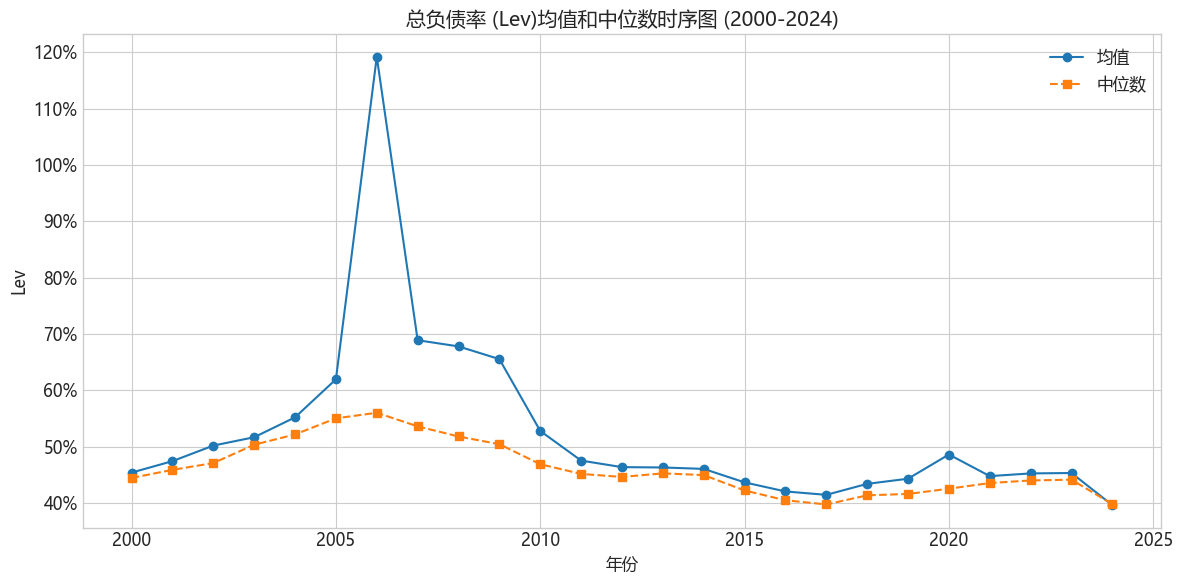

In [70]:
## 2. 时序图分析

# B1. 杠杆率(Lev)的均值和中位数时序图
if 'Lev' in ratio_stats:
    matplotlib.rc("font", family='Microsoft YaHei')
    fig = plot_time_series(ratio_stats['Lev'], 'Lev', '总负债率 (Lev)均值和中位数时序图 (2000-2024)', 'Lev')
    plt.savefig('results/lev_time_series.png')
    plt.show()

## 杠杆率(Lev)时序分析

1. 从杠杆率的时间序列图中，我们可以观察到：A股上市公司总负债率（Lev）均值与中位数的变化趋势整体呈现“前期上升—2006年异常波动—后期回落趋稳”的结构特征。

1. 2000至2005年，均值与中位数同步缓慢上升，反映出企业整体杠杆水平逐步提升。

1. 2006年出现极端异常，均值飙升至近120%，远超中位数，说明当年存在极少数负债率极高的企业，显著拉高了整体平均水平，而大多数企业则较为稳定。此后，均值迅速回落，至2010年已恢复至60%以下。

1. 2011年至2024年间，总负债率均值与中位数趋于平稳，均值维持在40%–45%之间，中位数稍低。两者差距显著缩小，表明高杠杆极端个案明显减少，企业财务结构趋于稳健，整体风险水平下降。


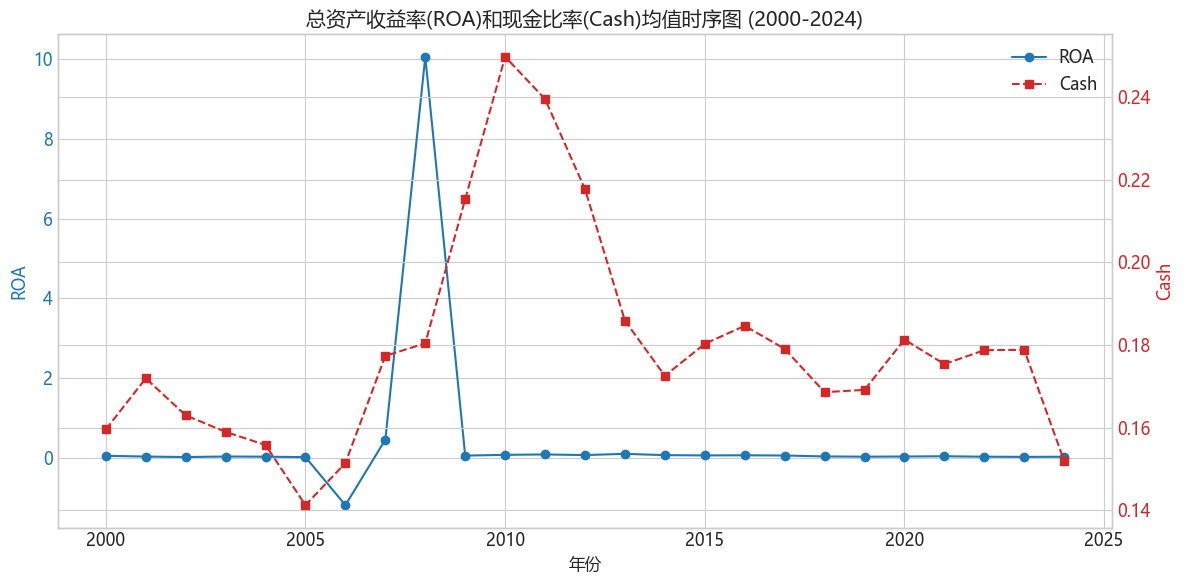

In [52]:
# B2. ROA和Cash的均值时序图（双Y轴）
if 'ROA' in ratio_stats and 'Cash' in ratio_stats:
    fig = plot_dual_time_series(ratio_stats['ROA'], ratio_stats['Cash'], 
                               'ROA', 'Cash', '总资产收益率(ROA)和现金比率(Cash)均值时序图 (2000-2024)')
    plt.savefig('results/roa_cash_time_series.png')
    plt.show()


## ROA和现金持有率时序分析

1. 从ROA和现金持有率的对比图中，我们可以观察到：A股上市公司总资产收益率（ROA）与现金比率（Cash）两者走势呈现出一定的反向关系，且均存在短期波动与极端值干扰。

1. ROA在2006–2008年间出现剧烈异常，2008年均值一度飙升至近10，随后迅速回落并稳定在0.02–0.07之间。这一异常很可能由极端个别公司利润异常拉升所致，并不代表整体企业盈利能力大幅提升。2010年之后，ROA整体走势趋于平稳，反映出企业资产使用效率处于低位并未明显改善。

1. 现金比率（Cash）则在2008–2011年间达到高点，2010年均值接近0.25，显示企业普遍提升了现金持有水平以应对外部不确定性。此后现金比率缓慢下降，并在近年维持在0.16–0.18区间。2024年Cash均值进一步下滑至0.15以下，可能反映出企业在稳健经营下逐步降低冗余现金占比，财务策略更为优化。

1. 整体来看，两者的变化揭示出A股企业在危机时期更倾向于提高现金持有以抵御风险，而盈利能力则长期保持低位且受极端值干扰较大。


In [53]:
# 原始中文名称 -> 字母代码的映射
industry_names = {
    'C': '制造业',
    'D': '电力、热力、燃气及水生产和供应业',
    'G': '交通运输业',
    'E': '建筑业',
    'K': '房地产业',
    'F': '批发和零售业',
    'J': '金融业'
}

# 构造反向映射字典 中文名 -> 英文字母
name_to_code = {v: k for k, v in industry_names.items()}

# 添加一列 industry_code（或者直接覆盖原列）
data['industry_code'] = data['industry_CSRC'].map(name_to_code)

# 筛选有效行业
industries = list(industry_names.keys())  # ['C', 'D', 'G', ...]
industry_df = data[data['industry_code'].isin(industries)]


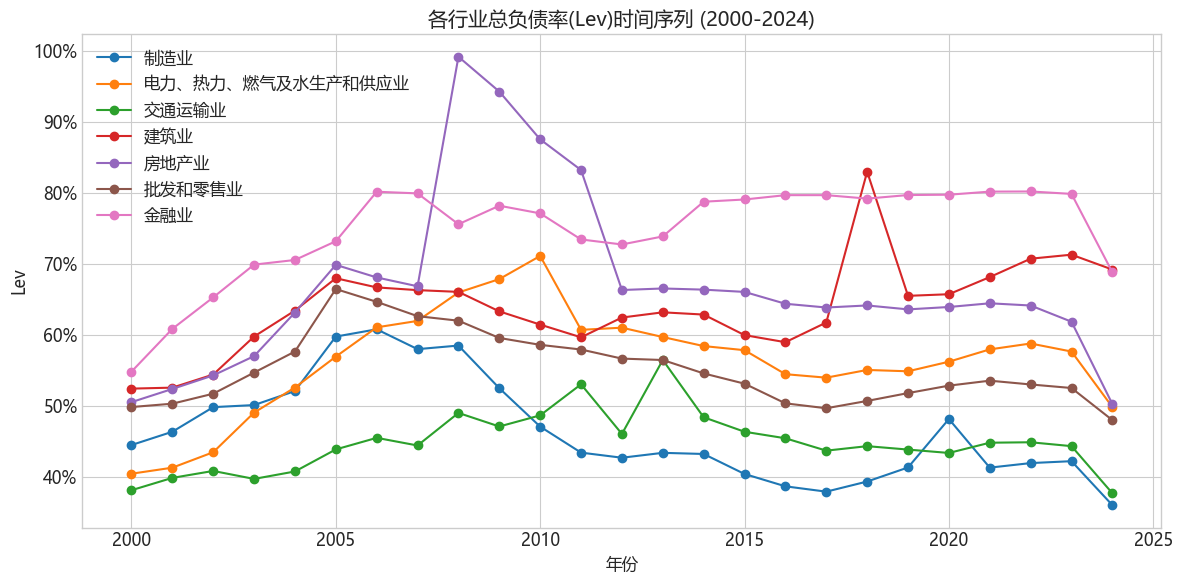

In [54]:
# 绘制行业杠杆率(Lev)时序图
if not industry_df.empty:
    fig = plot_industry_time_series(industry_df, industries, industry_names, 'Lev', 
                                  '各行业总负债率(Lev)时间序列 (2000-2024)')
    plt.savefig('results/industry_lev_time_series.png')
    plt.show()


## 行业杠杆率对比分析

1. 从各行业杠杆率的时间序列对比中，我们可以观察到：整体来看，房地产、批发零售与金融行业长期处于高杠杆水平。房地产行业在2009年前后达到接近100%的峰值，此后虽略有下降，但始终维持在较高区间。批发和零售业自2005年以来维持在80%左右的稳定高位，显示其对负债融资的高度依赖。金融业负债率则持续稳定在70%–80%之间，符合其资本密集型和高杠杆运营的行业特性。

1. 相较之下，制造业、交通运输业、电力及建筑业负债率相对较低且呈下降趋势。制造业和交通运输业在2010年后杠杆率显著下降，至2024年降至40%以下，说明这类实业型行业近年来更趋稳健。建筑业虽在2020年前出现一次明显上升，但随后迅速回落，整体波动较大，可能与项目周期性和宏观调控有关。

1. 值得注意的是，个别年份如2009年、2020年，部分行业出现异常波动，可能与外部经济冲击（如金融危机或疫情）相关。整体来看，各行业在经历2000年代的加杠杆扩张后，多数自2010年起逐步转向稳健的财务结构，反映出资本市场成熟度的提升与监管政策的逐步趋严。


In [67]:
# 创建行业年度指标表格
# 转换year为字符串以便比较
industry_df['year'] = industry_df['year'].astype(str)
target_years = [str(year) for year in range(2000, 2025)]

# 初始化结果DataFrame
industry_stats = pd.DataFrame()

# 为每个目标年份、行业和指标计算均值
for year in target_years:
    year_df = industry_df[industry_df['year'] == year]
    if not year_df.empty:
        for industry in industries:
            ind_df = year_df[year_df['industry_code'] == industry]
            if not ind_df.empty:
                for ratio in ['SLoan', 'LLoan', 'Lev', 'Cash', 'ROA', 'ROE']:
                    if ratio in ind_df.columns:
                        key = f"{year}_{industry}_{ratio}"
                        industry_stats.loc[key, '年份'] = year
                        industry_stats.loc[key, '行业'] = industry_names.get(industry, industry)
                        industry_stats.loc[key, '指标'] = ratio
                        industry_stats.loc[key, '均值'] = ind_df[ratio].mean()

# 数据透视表以便更好地展示

pivoted = industry_stats.pivot_table(
        values='均值', 
        index=['年份', '行业'],
        columns='指标'
    )
    
# 保存到CSV
pivoted.to_csv('results/industry_ratio_statistics.csv')
print("\n各行业关键财务指标统计 (选定年份):")
print("=" * 50)

pivoted


各行业关键财务指标统计 (选定年份):


指标                         Cash     LLoan       Lev       ROA       ROE     SLoan
年份   行业                                                                          
2000 交通运输业             0.135685  0.088502  0.380785  0.049852  0.075082  0.079268
     制造业               0.162964  0.060286  0.444421  0.050919  0.094592  0.152769
     建筑业               0.138789  0.042438  0.523869  0.038019  0.087157  0.159756
     房地产业              0.129055  0.040938  0.504844  0.016817 -0.001980  0.220158
     批发和零售业            0.156258  0.035546  0.497942  0.031376  0.048678  0.191533
     电力、热力、燃气及水生产和供应业  0.130413  0.085940  0.404032  0.057415  0.098237  0.108811
     金融业               0.177756  0.015532  0.547770  0.025417  0.052196  0.109322
2001 交通运输业             0.131241  0.099614  0.398165  0.040800  0.081014  0.092242
     制造业               0.175175  0.062340  0.463116  0.029764  0.084991  0.166031
     建筑业               0.180276  0.032931  0.525261  0.030707  0.080343  0.136144
     房地产业              0.145198  0.038218  0.523393  0.022465 -0.080805  0.237583
     批发和零售业            0.170834  0.030249  0.502643  0.028711  0.059729  0.195156
     电力、热力、燃气及水生产和供应业  0.136414  0.123295  0.412534  0.049850  0.087275  0.120171
     金融业               0.186576  0.028340  0.607993 -0.006131 -0.049107  0.108548
2002 交通运输业             0.136358  0.089603  0.407939  0.043711  0.054243  0.110482
     制造业               0.166290  0.060229  0.497788  0.011865  0.039566  0.176475
     建筑业               0.178559  0.045451  0.543679  0.032212  0.084012  0.117699
     房地产业              0.154167  0.045791  0.542494  0.004923  2.872016  0.222164
     批发和零售业            0.161468  0.033250  0.516715  0.018044  0.019274  0.189436
     电力、热力、燃气及水生产和供应业  0.135921  0.139621  0.434283  0.038836  0.064772  0.126984
     金融业               0.092338  0.022650  0.652376 -0.007520 -0.535883  0.064290
2003 交通运输业             0.144814  0.092069  0.396710  0.054027  0.105831  0.116694
     制造业               0.155910  0.060101  0.500709  0.038803  0.066400  0.181610
     建筑业               0.173933  0.035509  0.597203  0.032459  0.095961  0.136737
     房地产业              0.149539  0.059373  0.569630  0.010143  0.011010  0.227344
     批发和零售业            0.176581  0.028261  0.546464  0.014953 -0.034689  0.207190
     电力、热力、燃气及水生产和供应业  0.116941  0.156055  0.490106  0.000424  0.080322  0.146793
     金融业               0.083813  0.020323  0.698493 -0.009515  0.055757  0.068840
2004 交通运输业             0.143712  0.088894  0.407197  0.049943  0.096103  0.107554
     制造业               0.158820  0.056612  0.520432  0.037865  0.050132  0.187611
     建筑业               0.166362  0.037426  0.633774  0.026133  0.078654  0.154503
     房地产业              0.138538  0.062985  0.631076 -0.042041  0.091214  0.233524
     批发和零售业            0.168705  0.026664  0.576117  0.016560  0.094765  0.192958
     电力、热力、燃气及水生产和供应业  0.112466  0.163733  0.525425  0.014934  0.061497  0.161921
     金融业               0.079428  0.016362  0.705041  0.014118  0.041406  0.052392
2005 交通运输业             0.126280  0.103880  0.438249  0.055022  0.059333  0.107247
     制造业               0.142436  0.051843  0.597168  0.027469  0.021671  0.201898
     建筑业               0.156361  0.043687  0.679336 -0.003647 -0.007669  0.150485
     房地产业              0.129668  0.066366  0.698184 -0.012537 -0.001616  0.240987
     批发和零售业            0.167209  0.033008  0.664119 -0.006156  0.109076  0.190358
     电力、热力、燃气及水生产和供应业  0.087744  0.173553  0.568914  0.013743 -0.005575  0.165466
     金融业               0.064992  0.016520  0.731436 -0.012318 -0.014627  0.039364
2006 交通运输业             0.135699  0.102694  0.454552  0.063646  0.101732  0.116027
     制造业               0.149133  0.049844  0.607422  0.051203  0.114949  0.193940
     建筑业               0.167429  0.046006  0.666416  0.023159 -0.143836  0.150634
     房地产业              0.117489  0.082181  0.680448 -0.012491  0.213531  0.177689
     批发和零售业            0.173677  0.033544  0.646092  0.035956  0


## 行业财务指标年度均值分析（2000–2024）

这组数据展示了2000–2024年间 A 股各行业的 **短期借款比率（SLoan）**、**长期借款比率（LLoan）**、**总负债率（Lev）**、**现金比率（Cash）**、**资产收益率（ROA）** 和 **净资产收益率（ROE）** 的年度行业平均值。整体来看，不同行业在资本结构与盈利能力方面呈现出显著差异与演变趋势。

1. 借款结构分析

- **制造业、建筑业**等行业普遍具有较高的**短期借款比率（SLoan）**，说明融资方式以短期借贷为主。
- **长期借款比率（LLoan）**整体偏低，仅**金融业**维持在相对高位，反映其高杠杆运作的本质特征。
- **房地产业**在2009年前后短期负债占比较高，之后有所回落，显示融资结构有一定调整。

2. 总负债率（Lev）趋势

- **房地产业、金融业、批发零售业**的总负债率长期处于高位，表明这些行业对外部债务的依赖较重。
- 相较之下，**交通运输、制造业、电力行业**的杠杆水平较为稳健，特别是在2010年后呈现出**稳步去杠杆**的趋势。

3. 现金比率（Cash）变化

- 多数行业的现金比率在**2008–2011年达到高点**，与金融危机后的现金保守策略相关。
- 此后各行业逐步降低现金持有水平，趋于**资金使用效率优化**的目标，2024年多数行业现金比率已降至相对合理区间。

4. 盈利能力（ROA、ROE）表现

- **资产收益率（ROA）** 和 **净资产收益率（ROE）** 在2006–2009年间波动较大，受极端值干扰显著。
- **金融业 ROE** 波动尤为剧烈，间或出现高值但也伴随大幅下滑。
- **制造业、批发零售业**整体维持中等偏上水平，表现相对稳定。
- **房地产业**近年 ROA 和 ROE 明显下滑，甚至出现负值，显示出盈利能力面临较大压力。

5. 总结

行业间在负债结构、现金策略与盈利能力上差异显著，呈现出**“高杠杆—高波动”**与**“稳健—稳定收益”**的分化特征。近年来，多数行业表现出**降杠杆、降负债和盈利收缩**的趋势，反映出宏观调控与行业结构调整的深远影响。
